# 3 - Unsupervised Learning Task 
This work is for a project in TTT23. 
Group: Kim Duyen Le, Laura Feøy Ven, Live Standal Myklebust and Malin Rekdal

## Introduction 
We are using unsupervised learning to analyze 33 images of mice with tumors. We want to extract meaningful features from the images. 

The images display heatmaps representing the bioluminescence signal intensity resulting
from an injection of mammary carcinoma cells fraction enriched with extracellular vesicles.

The **objective** is to extract meaningfull features from the images capturing variations in signal intensity and other tumor characteristics. 

The **challanges** interpretability of the extracted features and insufficient data leading to less meaningfull or less diverse feature extraction. 

## Imports 

In [221]:
import os

import numpy as np
import matplotlib.pyplot as plt
import cv2
import umap

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

## Get data folders

In [222]:
input_folder = 'rawdata/'
output_folder = 'output_images/'

## For use in google drive: 
#input_folder = "drive/MyDrive/biomed/rawdata"
#output_folder = 'drive/MyDrive/biomed/outputdata/output_data/'

if os.path.exists(output_folder):
    print(f"Already have existing folder called {output_folder}, remove content or change name first.")
else:
    os.makedirs(output_folder)
    print(f"Output folder created: {output_folder}")


Output folder created: output_images/


## Load images, preprocess and augment data 
- Preprocessing: Normalize the pixel values. 
- Augmentation: Apply random rotations, zooming, flipping, and contrast. 

In [223]:
# With Augmentation 
def load_and_normalize_one_image(image_path):
    image = cv2.imread(image_path)
    img_normalized = cv2.normalize(image, None, 0, 1.0, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    return img_normalized  # Normalize: scale pixel values to [0, 1]

def augment_and_save_images(input_folder, output_folder):
    
    raw_images = []
    augmented_images = []
    for filename in os.listdir(input_folder):
        if filename.endswith(('.jpg', '.png')):
            image_path = os.path.join(input_folder, filename)
            image_array = load_and_normalize_one_image(image_path)

            # Save the original image
            original_output_path = os.path.join(output_folder, "raw_" + filename)
            cv2.imwrite(original_output_path, (image_array * 255).astype(np.uint8))
            raw_images.append(image_array)

            augmented_image = augment(image_array) # Augments image

            # Save the augmented image
            augmented_output_path = os.path.join(output_folder, "augmented_" + filename)
            cv2.imwrite(augmented_output_path, (augmented_image * 255).astype(np.uint8))
            augmented_images.append(augmented_image)
            
    return raw_images, augmented_images

def augment(image_array):
    data_augmentation = tf.keras.Sequential([
        keras.layers.RandomZoom(0.2),
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomContrast(0.2), 
        # keras.layers.RandomBrightness(0.1),
        keras.layers.RandomRotation(0.2),
    ])
    
    # Expand dimensions for the batch
    image_array = np.expand_dims(image_array, axis=0)

    # Apply data augmentation to the normalized image
    augmented_image = data_augmentation(image_array)
    augmented_image = augmented_image[0].numpy()

    return augmented_image

raw_images, augmented_images = augment_and_save_images(input_folder, output_folder)
print("Succesfully loaded and augmented images")


Succesfully loaded and augmented images


In [224]:
# Check that the right amount of images has been loaded. 
print(f"We have {len(raw_images)} raw images.") # Should be 33
print(f"We have {len(augmented_images)} augmented images.") # Should be 33

images = raw_images + augmented_images
print(f"Therefore, we have in total {len(images)} images.") # Should be 66

We have 33 raw images.
We have 33 augmented images.
Therefore, we have in total 66 images.


## Display some images

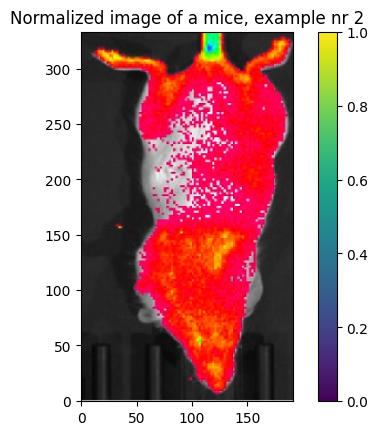

In [225]:
image_number_to_inspect = 2 # numer between 0 and 66 (but not 66)

if image_number_to_inspect >= len(images) or image_number_to_inspect < 0:
    print('There are only', len(images), 'images in this data set. Chose value between 1 and', len(images))
else:
    plt.imshow(images[image_number_to_inspect], aspect='equal', origin='lower')
    plt.colorbar()
    plt.title(f"Normalized image of a mice, example nr {image_number_to_inspect}")
    plt.show()

## Reshaping the input: 

In [226]:
# images -->  Each element is a 3D array corresponding to an RGB image (height, width, 3)

flattened_images = [image.flatten() for image in images] # Flattening the input

max_length = max(len(arr) for arr in flattened_images) # Determine the maximum length of all arrays

# Pad the arrays to the maximum length
padded_data = [np.pad(arr, (0, max_length - len(arr)), mode='reflect') for arr in flattened_images]
    # can adjust the padding mode to what is wanted (constant/reflect/etc. ) 

padded_data = np.array(padded_data) # Convert the list of padded arrays to a NumPy array


In [227]:
print("Some information about before and after padding and reshaping:")
print(f"Orignal shape of one image was {np.shape(images[0])}, and now it is flattened to have the shape {np.shape(flattened_images[0])}, but the size is variating from image to image. ")

print(" ")
print(f"We therefore did a padding so that all 1D arrays of the images has the same length. The new shape for all the images is {np.shape(padded_data[0])}, which means that the whole dataset has the shape {np.shape(padded_data)} ")

print(" ")
print("One example on before and after padding:")
num = 10
print(f"Length before {len(flattened_images[num])}")
print(f"Length after {len(padded_data[num])}")
print(f"Content before {flattened_images[num]}")
print(f"Content after {padded_data[num]}")

Some information about before and after padding and reshaping:
Orignal shape of one image was (353, 216, 3), and now it is flattened to have the shape (228744,), but the size is variating from image to image. 
 
We therefore did a padding so that all 1D arrays of the images has the same length. The new shape for all the images is (230832,), which means that the whole dataset has the shape (66, 230832) 
 
One example on before and after padding:
Length before 177936
Length after 230832
Content before [0.03137255 0.03137255 0.03137255 ... 0.15686275 0.15686275 0.15686275]
Content after [0.03137255 0.03137255 0.03137255 ... 0.8352942  0.8196079  0.8117648 ]


52896


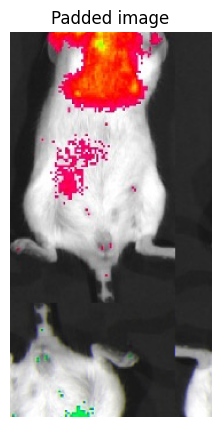

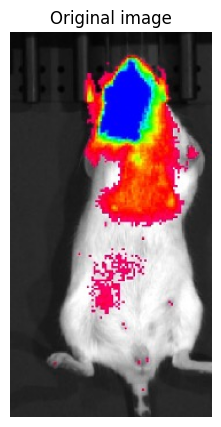

In [228]:
# Reconstructed image after padding to look at it: 
image_nr_to_inspect = 10

diff = len(padded_data[image_nr_to_inspect]) - len(flattened_images[image_nr_to_inspect])
org_shape = images[image_nr_to_inspect].shape
print(diff)

plt.figure(figsize=(10, 5))
reshaped_image = padded_data[image_nr_to_inspect][diff:].reshape(org_shape)  #
plt.imshow(reshaped_image, cmap='gray') 
plt.axis('off')
plt.title("Padded image")
plt.show()

plt.figure(figsize=(10, 5))
reshaped_image = flattened_images[image_nr_to_inspect].reshape(org_shape) 
plt.imshow(reshaped_image, cmap='gray')  
plt.axis('off')
plt.title("Original image")
plt.show()

## Feature Extraction 
Utilize PCA or Autoencoders, apply regularization if using Autoencoders. Also: Opt for simpler models or configurations.

Want to represent the data with fewer variables --> We construct new set of dimensions.

### PCA = Principal Component Analysis 
- Feature extraction by reducing higher vector spaces to a lover projection 

(10, 230832)
(10,)


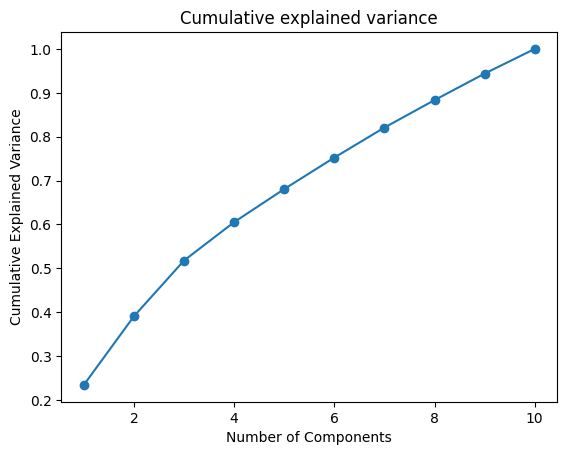

In [229]:
n_components = 10   # specify the number of components to extract --> to be adjusted
pca = PCA(n_components=n_components) # Create a PCA instance

pca.fit_transform(padded_data) # Fit the PCA model

# Access the principal components and the amount of variance they explain
components = pca.components_
print(np.shape(components)) # Hadde tenkt den sku bli (n_components, anall bilde) og ikkje (n_component, shape of image). 

explained_variance = pca.explained_variance_
print(np.shape(explained_variance))
cumulative_explained_variance = np.cumsum(explained_variance) / np.sum(explained_variance)

# Visualize the explained variance
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o')
plt.title("Cumulative explained variance")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.show()


The plot of cumulative explained variance shows how much of the total variance in the RGB image  is explained by each additional principal component. Each point represents the cumulative explained variance as we increase the number of PC used. In other words, this shows how much information is retained if we reduce the dimensionality of the data. This is just for knowing how many PC you should use, and then you can continue with that amount. 

In [230]:
# CONTINUE WITH ACTUALLY USING PC TO DO AN ANALYSIS IF WANTED. 
# We choose to focus on Autoencoders. 

### Autoencoders
Normally has an image in and image out, but uses bottleneck to represent the data in a simpler way. Because the model is forced to prioritize which aspects of the input should be copied, it often learns useful properties of the data. For feature extraction we can use the part up untill the bottlneck. 


In [244]:
# Define the Autoencoder architecture
input_dim = padded_data.shape[1] # The input dimension is now determined by the maximum length
encoding_dim = 5  # To be adjusted depending on how many features we want out. 

input_img = keras.Input(shape=(input_dim,))
encoded = layers.Dense(encoding_dim, activation='relu', activity_regularizer=keras.regularizers.l1(10e-5))(input_img)
# Can add more layers here and adapt the model here. 



In [245]:
# Extract features using the encoder
encoder = keras.Model(input_img, encoded)

encoded_features = encoder.predict(padded_data)

3/3 [==============================] - 0s 6ms/step


In [246]:
# Inspecting the features we got. 
print(encoded_features)

print(len(encoded_features)) # Should correspond to the amount of images we put in. 
print(len(encoded_features[0])) # Should correspond to the amount of features we choose to get out of the encoder. 

[[0.1554746  0.9286027  0.         0.6681732  0.        ]
 [0.47924128 1.5820746  0.         0.9430173  0.        ]
 [0.59047776 1.020684   0.08635289 0.79713726 0.        ]
 [0.9028532  0.9334856  0.30990067 0.1738739  0.        ]
 [0.49716556 1.8536084  0.         1.0276124  0.        ]
 [0.05914938 1.7789447  0.         1.5978028  0.        ]
 [0.61710894 1.2195085  0.         0.6995974  0.        ]
 [1.3552759  0.7352656  0.1670273  0.9298297  0.        ]
 [0.6049273  2.0637803  0.         0.96855253 0.        ]
 [0.473428   1.9523804  0.         0.66617954 0.08826394]
 [0.4549819  1.0661873  0.         0.6835843  0.        ]
 [0.8602181  2.0851421  0.         0.92396104 0.        ]
 [0.6477157  1.8058413  0.         0.8132867  0.        ]
 [0.59226096 2.48562    0.10692862 1.8533075  0.08609802]
 [0.45510796 1.4918392  0.         0.63829833 0.        ]
 [0.8116214  1.7247392  0.         0.26158643 0.        ]
 [0.30503547 2.316662   0.         0.3677926  0.        ]
 [0.80660594 1

## Visualization and Evaluation
Evaluate the usefulness of the extracted features using domain-specific metrics or visualization techniques
Use techniques like t-SNE or UMAP for visualization. 

(66, 2)


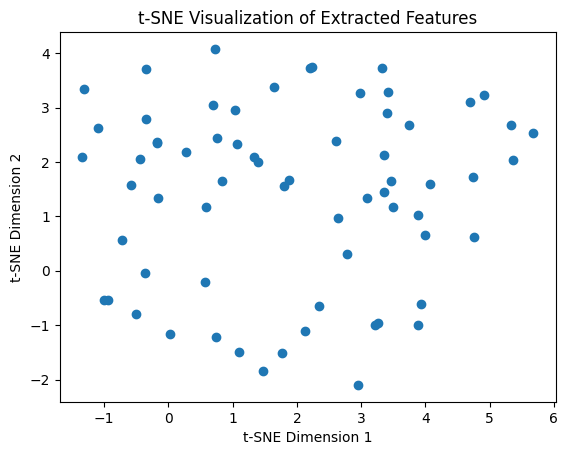

In [247]:
tsne = TSNE(n_components=2)  # Adjust the number of components for 2D or 3D visualization
reduced_features = tsne.fit_transform(encoded_features)
print(np.shape(reduced_features))

# Visualize the reduced features
plt.scatter(reduced_features[:, 0], reduced_features[:, 1])
plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

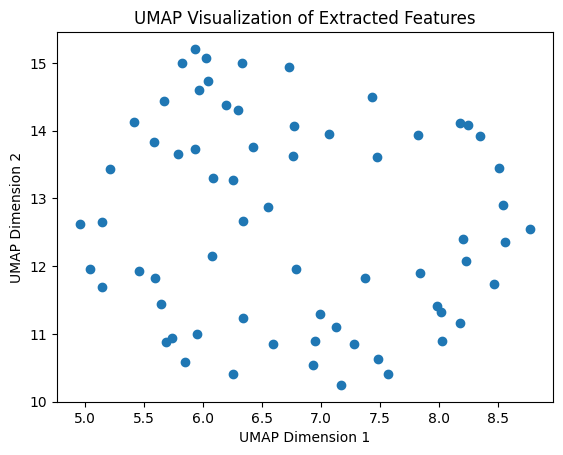

In [248]:
reducer = umap.UMAP(n_components=2) # Adjust the number of components for 2D or 3D visualization
embedding = reducer.fit_transform(encoded_features)

# Visualize the UMAP reduced features
plt.scatter(embedding[:, 0], embedding[:, 1])
plt.title('UMAP Visualization of Extracted Features')
plt.xlabel('UMAP Dimension 1')
plt.ylabel('UMAP Dimension 2')
plt.show()


## Clustering (optional)
Employ clustering algorithms like K-means

In [249]:
# Kmeans algorithm with different values of K (number of clusters)
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
max_num_clusters = 10 # To be adjusted
K = range(1, max_num_clusters + 1)

for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(encoded_features)
    kmeanModel.fit(encoded_features)
 
    distortions.append(sum(np.min(cdist(encoded_features, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / encoded_features.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(encoded_features, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / encoded_features.shape[0]
    mapping2[k] = kmeanModel.inertia_

C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMean

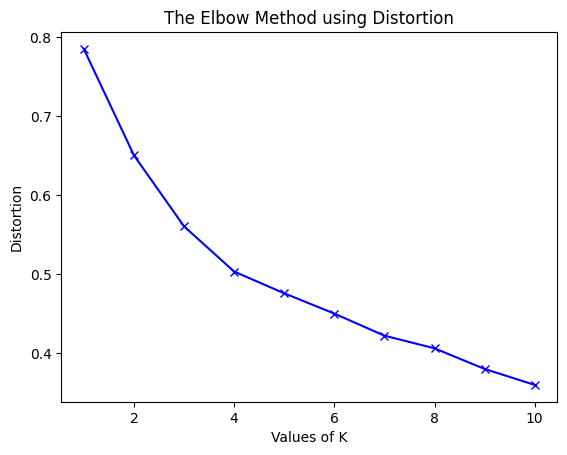

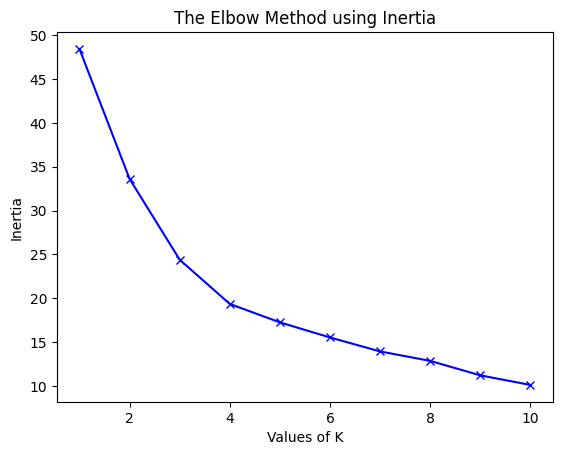

In [250]:
# Elbow Plot of distortions
plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

# Elbow plot of intertias
plt.plot(K, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The Elbow Method using Inertia')
plt.show()

C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


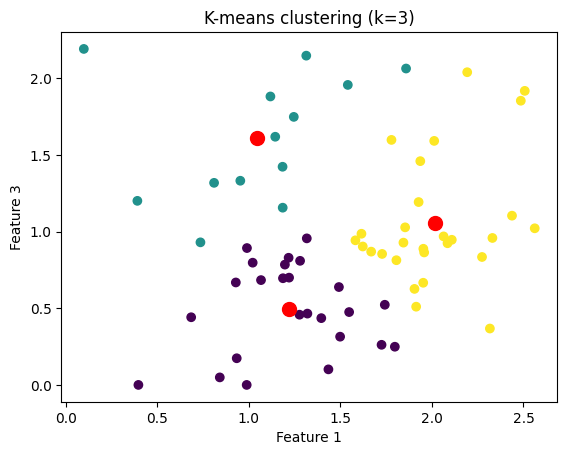

In [255]:
#Cluster plot
k = 3 # choose the best k from result from The Elbow plot 

f1, f2 = 1, 3 # Define features to plot --> change these to see a different plot. 

kmeans = KMeans(n_clusters=k, \
                    init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(encoded_features)
plt.scatter(encoded_features[:, f1], encoded_features[:, f2], c=y_kmeans)
plt.scatter(kmeans.cluster_centers_[:, f1],\
            kmeans.cluster_centers_[:, f2], \
            s=100, c='red')
plt.title('K-means clustering (k={})'.format(k))
plt.xlabel(f'Feature {f1}')
plt.ylabel(f'Feature {f2}')
plt.show()

C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\malin\anaconda3\envs\BiomedConda\lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


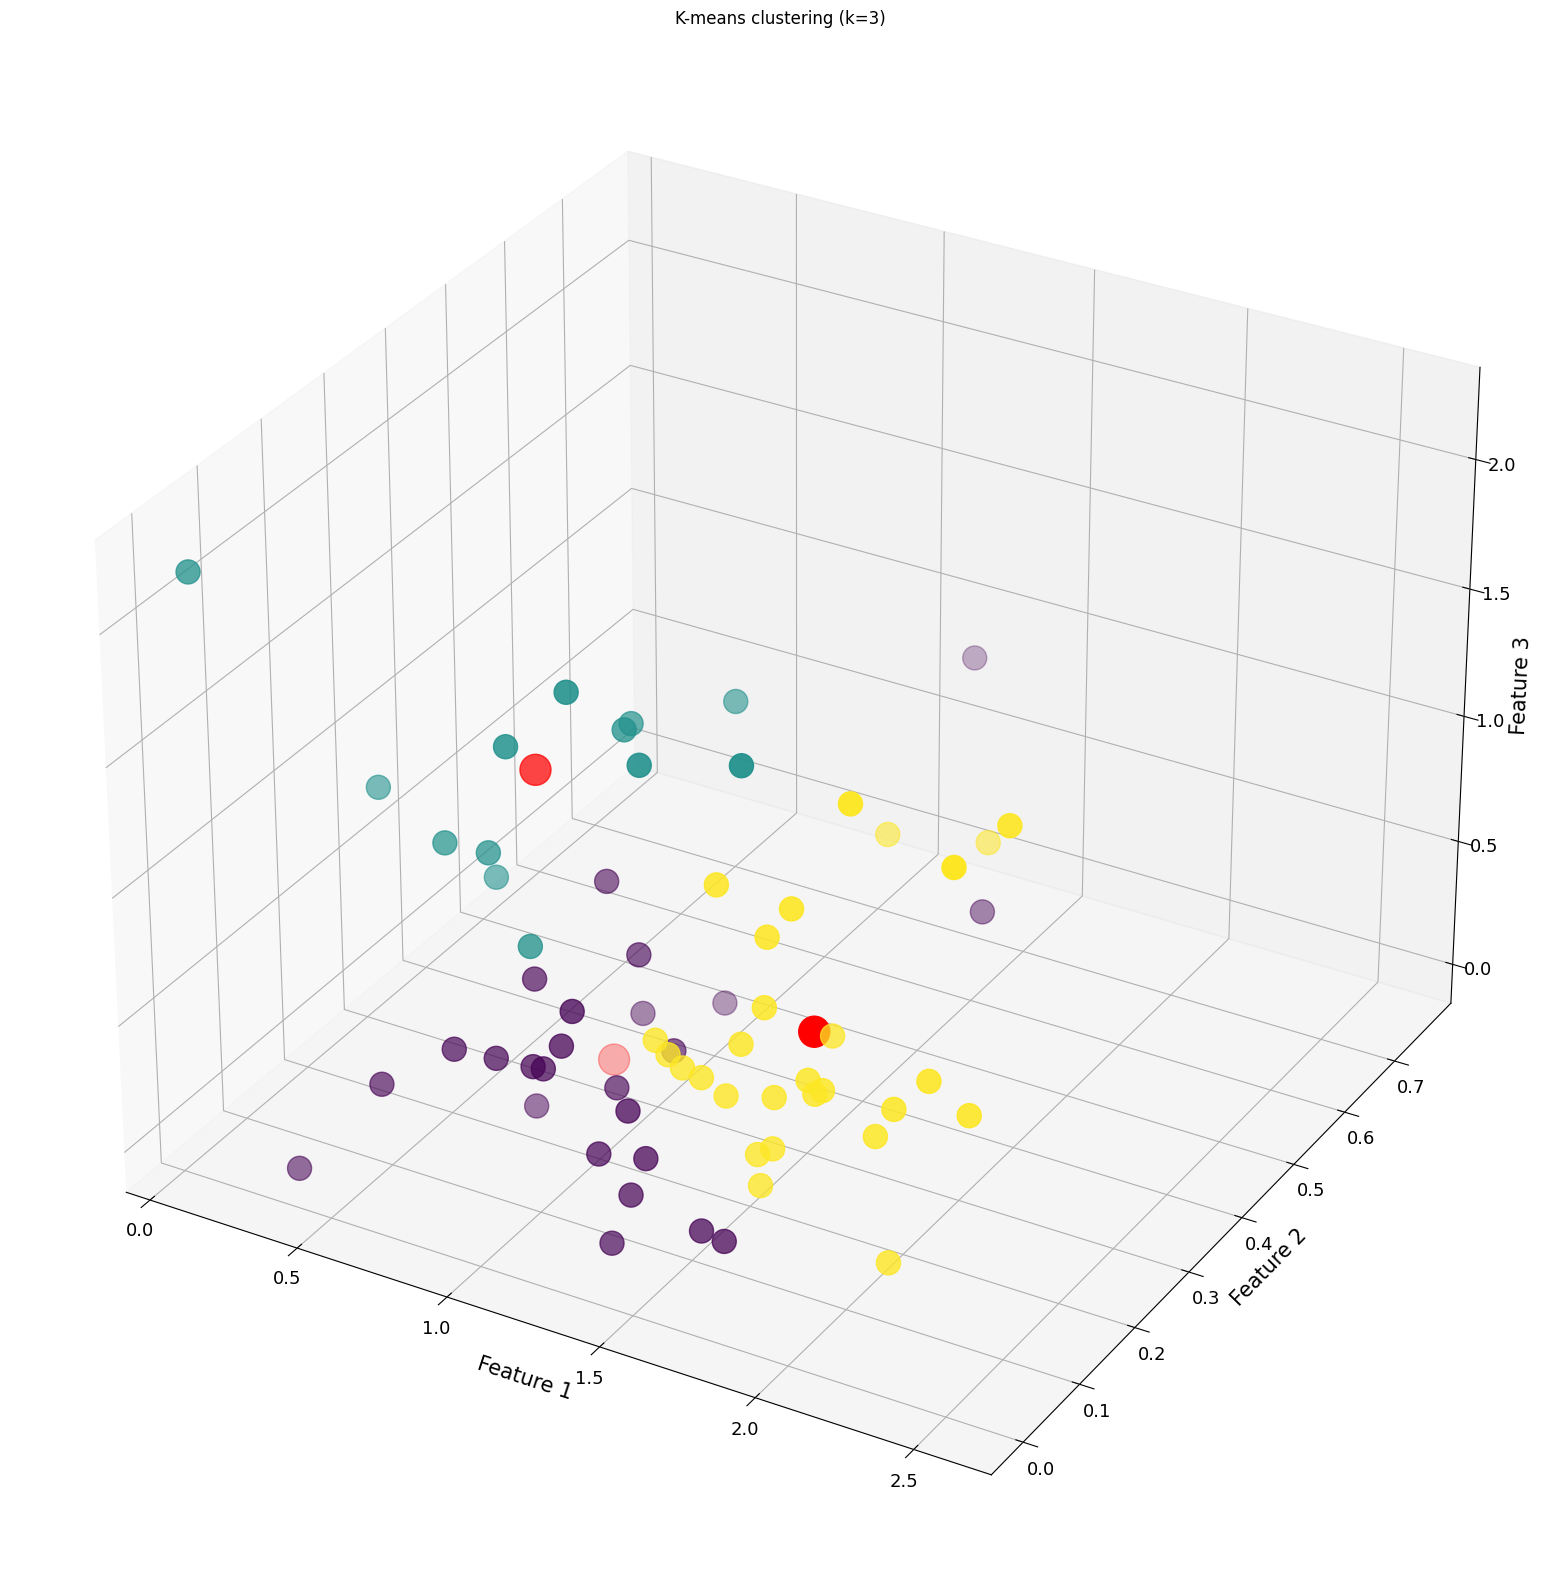

In [252]:
#Cluster plot in 3D

f1, f2, f3 = 1, 2, 3 # Define features to plot --> change these to see a different plot. 

kmeans = KMeans(n_clusters=k, \
                    init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(encoded_features)
fig = plt.figure(figsize=(20, 20))
ax = plt.axes(projection = "3d") 
ax.scatter3D(encoded_features[:, f1], encoded_features[:, f2],encoded_features[:, f3], s = 300, c=y_kmeans)
ax.scatter3D(kmeans.cluster_centers_[:, f1],\
            kmeans.cluster_centers_[:, f2], \
            kmeans.cluster_centers_[:, f3], \
            s=500, c='red')
plt.title('K-means clustering (k={})'.format(k))
ax.tick_params(labelsize = 13)
ax.set_xlabel(f'Feature {f1}', fontsize = 15)
ax.set_ylabel(f'Feature {f2}', fontsize = 15)
ax.set_zlabel(f'Feature {f3}', fontsize = 15)
plt.show()